In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import kagglehub

In [ ]:
path = kagglehub.dataset_download("a2015003713/militaryaircraftdetectiondataset")

print("Path to dataset files:", path)

100%|██████████| 9.78G/9.78G [08:28<00:00, 20.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/a2015003713/militaryaircraftdetectiondataset/versions/86


In [16]:
!mv /sample_data/ /content/sample_data/

In [17]:
import os

num_skipped = 0

for folder_name in ("F16", "Mi24", "B1", "C130"):
  folder_path = os.path.join("sample_data", "sample_data", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [19]:
image_size = (180, 180)
batch_size = 32
class_names = ["F16", "Mi24", "B1", "C130"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "sample_data/sample_data",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=class_names,
    label_mode="categorical"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "sample_data/sample_data",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=class_names,
    label_mode="categorical"
)

Found 4163 files belonging to 4 classes.
Using 3331 files for training.
Found 4163 files belonging to 4 classes.
Using 832 files for validation.


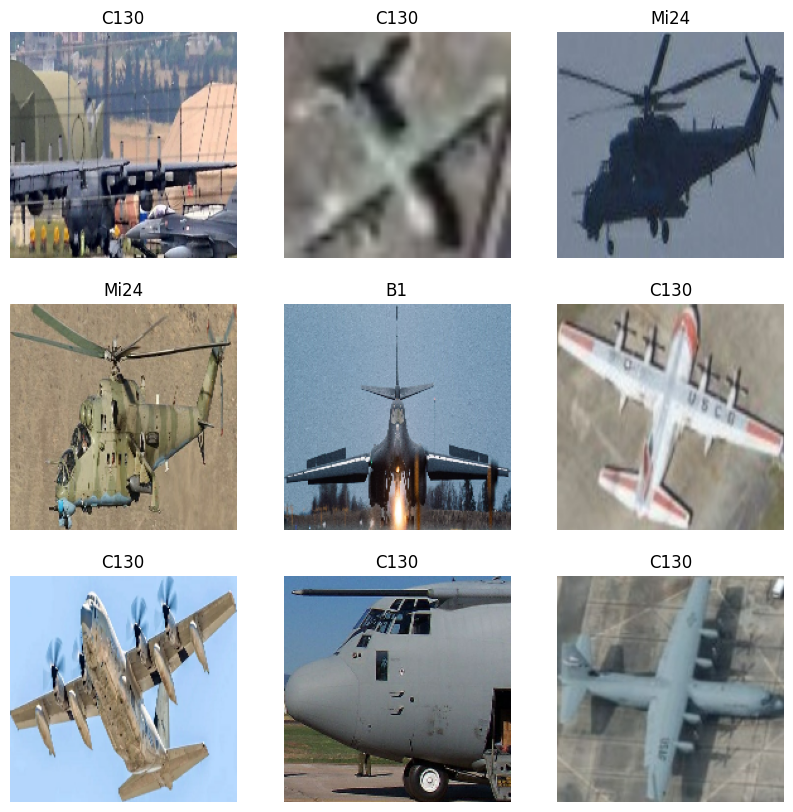

In [21]:
import matplotlib.pyplot as plt

class_names = train_ds.class_names  # ['F16', 'Mi24', 'B1', 'C130']

plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        class_index = tf.argmax(labels[i]).numpy()
        plt.title(class_names[class_index])

        plt.axis("off")


In [22]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

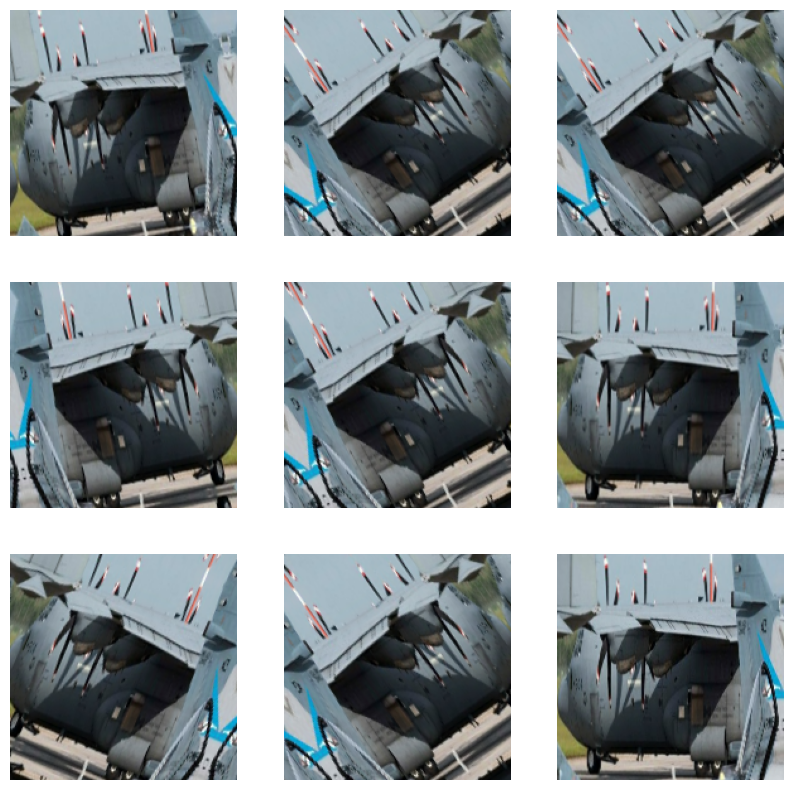

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [26]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)
  x = data_augmentation(inputs)

  x = layers.Rescaling(1.0 / 255)(x)
  x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(64, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x

  for size in [128, 256, 512, 728]:
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual])
    previous_block_activation = x

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units=units, activation=activation)(x)

  return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=4)
keras.utils.plot_model(model, show_shapes=True)

In [28]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
    keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor="val_accuracy")
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8997 - loss: 0.2750

105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 267ms/step - accuracy: 0.8997 - loss: 0.2749 - val_accuracy: 0.8582 - val_loss: 0.4194
Epoch 2/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8945 - loss: 0.2893

105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - accuracy: 0.8946 - loss: 0.2890 - val_accuracy: 0.8462 - val_loss: 0.4361
Epoch 3/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9240 - loss: 0.2105

105/105 ━━━━━━━━━━━━━━━━━━━━ 44s 285ms/step - accuracy: 0.9239 - loss: 0.2106 - val_accuracy: 0.7572 - val_loss: 0.9103
Epoch 4/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9088 - loss: 0.2408

105/105 ━━━━━━━━━━━━━━━━━━━━ 38s 261ms/step - accuracy: 0.9088 - loss: 0.2405 - val_accuracy: 0.8341 - val_loss: 0.5304
Epoch 5/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8957 - loss: 0.2688

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - accuracy: 0.8960 - loss: 0.2680 - val_accuracy: 0.8353 - val_loss: 0.5063
Epoch 6/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9028 - loss: 0.2534

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.9030 - loss: 0.2532 - val_accuracy: 0.7668 - val_loss: 0.8244
Epoch 7/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9054 - loss: 0.2704

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 254ms/step - accuracy: 0.9056 - loss: 0.2700 - val_accuracy: 0.8558 - val_loss: 0.4840
Epoch 8/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9256 - loss: 0.1923

105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 264ms/step - accuracy: 0.9257 - loss: 0.1919 - val_accuracy: 0.8654 - val_loss: 0.4070
Epoch 9/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9060 - loss: 0.2525

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.9061 - loss: 0.2522 - val_accuracy: 0.8438 - val_loss: 0.4536
Epoch 10/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9114 - loss: 0.2338

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.9115 - loss: 0.2336 - val_accuracy: 0.8462 - val_loss: 0.5348
Epoch 11/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8834 - loss: 0.3295

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.8837 - loss: 0.3285 - val_accuracy: 0.8053 - val_loss: 0.5686
Epoch 12/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9494 - loss: 0.1526

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.9493 - loss: 0.1528 - val_accuracy: 0.8702 - val_loss: 0.4263
Epoch 13/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9293 - loss: 0.1759

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.9294 - loss: 0.1757 - val_accuracy: 0.8534 - val_loss: 0.6003
Epoch 14/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9431 - loss: 0.1704

105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 264ms/step - accuracy: 0.9431 - loss: 0.1702 - val_accuracy: 0.8389 - val_loss: 0.5233
Epoch 15/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9348 - loss: 0.1676

105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 262ms/step - accuracy: 0.9348 - loss: 0.1676 - val_accuracy: 0.8245 - val_loss: 0.6153
Epoch 16/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9286 - loss: 0.1843

105/105 ━━━━━━━━━━━━━━━━━━━━ 40s 254ms/step - accuracy: 0.9287 - loss: 0.1841 - val_accuracy: 0.8317 - val_loss: 0.6064
Epoch 17/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9332 - loss: 0.1868

105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 264ms/step - accuracy: 0.9333 - loss: 0.1865 - val_accuracy: 0.8582 - val_loss: 0.4208
Epoch 18/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8917 - loss: 0.3022

105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 287ms/step - accuracy: 0.8922 - loss: 0.3009 - val_accuracy: 0.8798 - val_loss: 0.4112
Epoch 19/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9430 - loss: 0.1414

105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 253ms/step - accuracy: 0.9431 - loss: 0.1413 - val_accuracy: 0.8486 - val_loss: 0.5788
Epoch 20/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9312 - loss: 0.1943

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.9314 - loss: 0.1939 - val_accuracy: 0.8798 - val_loss: 0.3957
Epoch 21/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9179 - loss: 0.2187

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - accuracy: 0.9181 - loss: 0.2182 - val_accuracy: 0.8702 - val_loss: 0.4042
Epoch 22/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9559 - loss: 0.1243

105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 267ms/step - accuracy: 0.9559 - loss: 0.1243 - val_accuracy: 0.7873 - val_loss: 0.8403
Epoch 23/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9082 - loss: 0.2464

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - accuracy: 0.9085 - loss: 0.2457 - val_accuracy: 0.8113 - val_loss: 0.6769
Epoch 24/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9047 - loss: 0.2832

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 254ms/step - accuracy: 0.9051 - loss: 0.2819 - val_accuracy: 0.8678 - val_loss: 0.4803
Epoch 25/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9517 - loss: 0.1436

105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 263ms/step - accuracy: 0.9518 - loss: 0.1435 - val_accuracy: 0.8666 - val_loss: 0.4847
Epoch 26/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9585 - loss: 0.1288

105/105 ━━━━━━━━━━━━━━━━━━━━ 30s 289ms/step - accuracy: 0.9585 - loss: 0.1286 - val_accuracy: 0.6959 - val_loss: 1.5296
Epoch 27/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9445 - loss: 0.1319

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - accuracy: 0.9446 - loss: 0.1317 - val_accuracy: 0.8714 - val_loss: 0.4617
Epoch 28/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9486 - loss: 0.1439

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 255ms/step - accuracy: 0.9487 - loss: 0.1436 - val_accuracy: 0.8534 - val_loss: 0.5874
Epoch 29/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9694 - loss: 0.0968

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.9694 - loss: 0.0969 - val_accuracy: 0.8786 - val_loss: 0.4244
Epoch 30/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9555 - loss: 0.1242

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 260ms/step - accuracy: 0.9555 - loss: 0.1243 - val_accuracy: 0.8534 - val_loss: 0.5137
Epoch 31/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9551 - loss: 0.1340

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 258ms/step - accuracy: 0.9552 - loss: 0.1338 - val_accuracy: 0.8774 - val_loss: 0.4767
Epoch 32/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9247 - loss: 0.2201

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 254ms/step - accuracy: 0.9249 - loss: 0.2194 - val_accuracy: 0.8894 - val_loss: 0.4386
Epoch 33/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9250 - loss: 0.2078

105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 259ms/step - accuracy: 0.9252 - loss: 0.2069 - val_accuracy: 0.8582 - val_loss: 0.5367
Epoch 34/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9488 - loss: 0.1498

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 258ms/step - accuracy: 0.9489 - loss: 0.1494 - val_accuracy: 0.8546 - val_loss: 0.5906
Epoch 35/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9587 - loss: 0.1142

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 255ms/step - accuracy: 0.9588 - loss: 0.1139 - val_accuracy: 0.8041 - val_loss: 0.8390
Epoch 36/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9256 - loss: 0.2207

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.9259 - loss: 0.2198 - val_accuracy: 0.8474 - val_loss: 0.6889
Epoch 37/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9536 - loss: 0.1389

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 257ms/step - accuracy: 0.9536 - loss: 0.1386 - val_accuracy: 0.8774 - val_loss: 0.4876
Epoch 38/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9518 - loss: 0.1259

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - accuracy: 0.9518 - loss: 0.1257 - val_accuracy: 0.9002 - val_loss: 0.3368
Epoch 39/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9633 - loss: 0.1098

105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 260ms/step - accuracy: 0.9632 - loss: 0.1099 - val_accuracy: 0.8618 - val_loss: 0.5159
Epoch 40/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9630 - loss: 0.1054

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 257ms/step - accuracy: 0.9631 - loss: 0.1053 - val_accuracy: 0.8738 - val_loss: 0.3915
Epoch 41/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9760 - loss: 0.0710

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 253ms/step - accuracy: 0.9760 - loss: 0.0710 - val_accuracy: 0.8834 - val_loss: 0.3681
Epoch 42/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9591 - loss: 0.1103

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 254ms/step - accuracy: 0.9591 - loss: 0.1102 - val_accuracy: 0.8666 - val_loss: 0.5652
Epoch 43/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9571 - loss: 0.1335

105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 267ms/step - accuracy: 0.9572 - loss: 0.1330 - val_accuracy: 0.8606 - val_loss: 0.5108
Epoch 44/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9728 - loss: 0.0801

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 260ms/step - accuracy: 0.9728 - loss: 0.0802 - val_accuracy: 0.8642 - val_loss: 0.5106
Epoch 45/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9050 - loss: 0.2531

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.9053 - loss: 0.2523 - val_accuracy: 0.8582 - val_loss: 0.5219
Epoch 46/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9568 - loss: 0.1208

105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 263ms/step - accuracy: 0.9569 - loss: 0.1205 - val_accuracy: 0.8786 - val_loss: 0.5100
Epoch 47/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8945 - loss: 0.2973

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 261ms/step - accuracy: 0.8949 - loss: 0.2960 - val_accuracy: 0.8546 - val_loss: 0.5234
Epoch 48/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9177 - loss: 0.1955

105/105 ━━━━━━━━━━━━━━━━━━━━ 27s 252ms/step - accuracy: 0.9181 - loss: 0.1946 - val_accuracy: 0.8858 - val_loss: 0.3934
Epoch 49/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9502 - loss: 0.1512

105/105 ━━━━━━━━━━━━━━━━━━━━ 44s 284ms/step - accuracy: 0.9504 - loss: 0.1506 - val_accuracy: 0.8990 - val_loss: 0.3420
Epoch 50/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9620 - loss: 0.1043

105/105 ━━━━━━━━━━━━━━━━━━━━ 28s 263ms/step - accuracy: 0.9621 - loss: 0.1041 - val_accuracy: 0.8690 - val_loss: 0.4466


In [31]:
!ls

best_from_4_classes.h5	save_at_16.h5  save_at_24.h5  save_at_32.h5  save_at_40.h5  save_at_49.h5
model.png		save_at_17.h5  save_at_25.h5  save_at_33.h5  save_at_41.h5  save_at_4.h5
sample_data		save_at_18.h5  save_at_26.h5  save_at_34.h5  save_at_42.h5  save_at_50.h5
save_at_10.h5		save_at_19.h5  save_at_27.h5  save_at_35.h5  save_at_43.h5  save_at_5.h5
save_at_11.h5		save_at_1.h5   save_at_28.h5  save_at_36.h5  save_at_44.h5  save_at_6.h5
save_at_12.h5		save_at_20.h5  save_at_29.h5  save_at_37.h5  save_at_45.h5  save_at_7.h5
save_at_13.h5		save_at_21.h5  save_at_2.h5   save_at_38.h5  save_at_46.h5  save_at_8.h5
save_at_14.h5		save_at_22.h5  save_at_30.h5  save_at_39.h5  save_at_47.h5  save_at_9.h5
save_at_15.h5		save_at_23.h5  save_at_31.h5  save_at_3.h5   save_at_48.h5
